In [161]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random

In [3]:
data_dir = Path('../../data')

## Loading Prepared data

In [134]:
ewing_df = pd.read_csv(data_dir / 'Ewing_cell_lines/Ewing_NT_cell_lines.csv', index_col=0)
train_Y_df = pd.read_csv(data_dir / 'mat4-CellO_train-ewing_genes.csv', index_col=0)

In [135]:
Z_df = pd.read_csv(data_dir / 'plierResult-cello_train/Z.csv')
Z_df = Z_df[Z_df.index.isin(ewing_df.columns)]
Z_mat = Z_df.values

In [136]:
# sorting columns according to Z
train_Y_df = train_Y_df[Z_df.index]
ewing_df = ewing_df[Z_df.index]

In [137]:
assert (train_Y_df.columns != ewing_df.columns).sum() == 0
assert (train_Y_df.columns != Z_df.index).sum() == 0

### Normalization

In [138]:
# computing normalization values on train dataset
per_gene_mean = train_Y_df.mean().values
per_gene_std = train_Y_df.std().values

train_y_vectors = (train_Y_df.values - per_gene_mean) / per_gene_std
test_y_vectors = (ewing_df.values - per_gene_mean) / per_gene_std

### Using regression to find the B that will produce vectors close to test Y

In [67]:
from numpy.linalg import inv

In [68]:
X = Z_mat

# linear least squares
# check this for more details: https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/
b_test = inv(X.T.dot(X)).dot(X.T).dot(test_y_vectors.T)
b_test.shape

(512, 11)

In [69]:
y_test_hat = Z_mat.dot(b_test).transpose()

In [70]:
y_test_hat.shape

(11, 5775)

In [71]:
def pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

In [72]:
y2y_hat_dists = pearson_dists(test_y_vectors, y_test_hat)
y2y_random_dists = pearson_dists(
    test_y_vectors, 
    random.sample(test_y_vectors.tolist(), len(test_y_vectors))
)

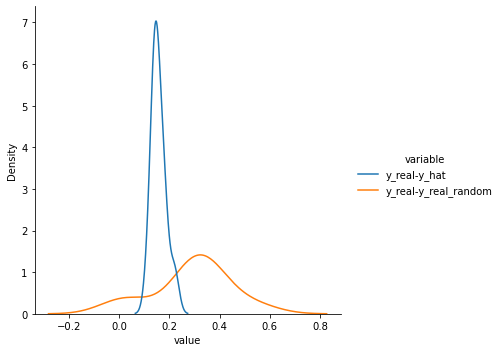

In [73]:
dists_df = pd.DataFrame({
    'y_real-y_hat': y2y_hat_dists,
    'y_real-y_real_random': y2y_random_dists
})

sns.displot(
    data=pd.melt(dists_df, value_vars=dists_df.columns), 
    x='value', hue='variable', kind='kde')

## Validating embeddings

In [74]:
import sys
sys.path.append('../../onto_lib')

In [77]:
from anndata import AnnData
import json
import scanpy as sc
import general_ontology_tools as got

In [78]:
with open(data_dir / 'CellO_data/bulk_RNA_seq_training_set/bulk_labels.json', 'r') as f:
    sample2cell_types_ids = json.load(f)

In [79]:
sample2types = {
    sample: list(map(got.get_term_name, types_ids))
    for sample, types_ids in sample2cell_types_ids.items()
}

In [81]:
test_b_vectors = b_test.T
test_samples = ewing_df.index.values

In [98]:
B_df = pd.read_csv(data_dir / 'plierResult-cello_train/B.csv').transpose()
B_df.shape

(3609, 512)

In [99]:
b_test_df = pd.DataFrame(test_b_vectors)
b_test_df.index = test_samples
b_test_df.columns = B_df.columns
b_test_df.shape

(11, 512)

In [100]:
B_full = pd.concat([B_df, b_test_df])
B_full.shape

(3620, 512)

In [139]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
types_per_b_samples = B_df.index.map(sample2types).values

train_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_df.index)

In [140]:
types_dummies = pd.concat([train_dummies, b_test_df])[train_dummies.columns]

In [141]:
test_mask = B_full.index.isin(test_samples)
train_mask = ~test_mask

In [163]:
ad = AnnData(B_full)

In [164]:
sc.pp.neighbors(ad, use_rep='X', n_neighbors=30)
sc.tl.umap(ad)

In [183]:
def as_category(data):
    return pd.Series(data).astype('category').values

# Add cell type annotations to AnnData object
for ct in types_dummies.columns:
    dummy_mask = types_dummies[ct] == 1
    ct_values = types_dummies[ct].copy()
    ct_values[~dummy_mask] = None
    ct_values[dummy_mask & train_mask] = 'train'
    ct_values[test_mask] = 'test'
    
    ad.obs[ct] = as_category(ct_values)    
    ad.obs[ct + ' - train'] = as_category(dummy_mask & ~test_mask)

ad.obs['test_sample'] = as_category(test_mask)

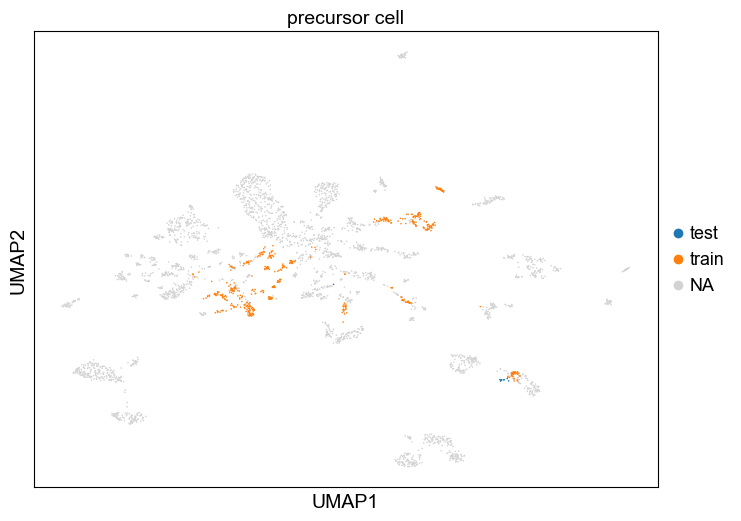

In [186]:
sc.set_figure_params(dpi=100)
plt.rcParams['figure.figsize'] = (8, 6)

for ctype in ['precursor cell']:
    sc.pl.umap(ad, color=ctype, size=5, groups=['test', 'train'])

## Classification

In [116]:
from sklearn.metrics import precision_score, recall_score

def get_pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

def get_pearson_dists_mat(vectors_a, vectors_b):
    return np.array([
        # repeat the A vector for each B vector
        get_pearson_dists(np.array(vector_a[np.newaxis, :]).repeat(len(vectors_b), axis=0), vectors_b)
        for vector_a in vectors_a
    ])

In [118]:
B_mat = B_df.values
B_mat.shape

(3609, 512)

In [146]:
import numpy as np
train_samples = train_Y_df.index.values

In [121]:
# pearson_dists = get_pearson_dists_mat(B_mat, b_test.T)
# pearson_dists.shape

(3609, 11)

In [147]:
# distances is a n_test X n_train matrix
# with columns for test items and rows for train items
dists_df = pd.DataFrame(pearson_dists)
dists_df.columns = test_samples
dists_df.index = train_samples

In [148]:
dists_df

,SRX1025875,SRX1025870,SRX1025865,SRX4587813,SRX1025860,SRX4587810,SRX4587809,SRX4587814,SRX4587812,SRX4587811,SRX3183024
SRX890545,1.123341,1.093080,1.149312,1.176287,1.130003,1.162682,1.179348,1.172930,1.176636,1.174408,1.153624
SRX1067711,1.095372,1.070512,1.092030,1.146400,1.091306,1.145884,1.151763,1.151244,1.151614,1.149509,1.162105
SRX1067710,1.092076,1.068337,1.071123,1.117138,1.075141,1.121766,1.123312,1.127038,1.127990,1.127672,1.134322
SRX762971,1.189891,1.112461,1.152034,1.275148,1.137693,1.302435,1.271560,1.293856,1.280613,1.295817,1.232885
SRX762970,1.168876,1.119433,1.144632,1.230069,1.148199,1.257260,1.230887,1.249439,1.237513,1.251924,1.192815
...,...,...,...,...,...,...,...,...,...,...,...
SRX3399308,1.161585,1.160889,1.164010,1.175520,1.164991,1.155323,1.172775,1.173294,1.173528,1.166850,1.002303
SRX3399309,1.153807,1.136562,1.158399,1.142142,1.166722,1.135918,1.137730,1.144402,1.139293,1.139152,1.000138
SRX3399310,1.128456,1.138202,1.147428,1.123640,1.136540,1.098468,1.118481,1.116609,1.120599,1.113357,0.982749
SRX3399311,1.190447,1.191499,1.198184,1.168041,1.187077,1.159714,1.172222,1.173133,1.170796,1.171192,1.038376


In [178]:
test_sample2closest_train = {
    # get the column for current test sample and find the index of raw the closest value
    sample_id: dists_df[sample_id].sort_values().index[:10]
    for sample_id in test_samples
}

In [179]:
cell_types_y_predicted = pd.DataFrame([
    types_dummies.loc[test_sample2closest_train[test_id]].sum()
    for test_id in test_samples
])

In [187]:
sum_per_ctype = cell_types_y_predicted.sum()
interesting_types = sum_per_ctype[(sum_per_ctype > 1) & (sum_per_ctype < 100)].sort_values(ascending=False)
interesting_types

precursor cell                        68.0
non-terminally differentiated cell    67.0
connective tissue cell                63.0
bone cell                             58.0
osteoblast                            58.0
neural cell                           24.0
glial cell                            22.0
neuron associated cell                22.0
glial cell (sensu Vertebrata)         22.0
astrocyte                             14.0
macroglial cell                       14.0
muscle precursor cell                  9.0
myoblast                               9.0
radial glial cell                      8.0
stuff accumulating cell                6.0
melanocyte                             6.0
pigment cell                           6.0
epithelial cell                        5.0
fibroblast                             4.0
fibroblast of dermis                   4.0
hematopoietic cell                     4.0
skin fibroblast                        4.0
polyploid cell                         3.0
endopolyplo

In [191]:
interesting_types = interesting_types[interesting_types > 2]
interesting_types

precursor cell                        68.0
non-terminally differentiated cell    67.0
connective tissue cell                63.0
bone cell                             58.0
osteoblast                            58.0
neural cell                           24.0
glial cell                            22.0
neuron associated cell                22.0
glial cell (sensu Vertebrata)         22.0
astrocyte                             14.0
macroglial cell                       14.0
muscle precursor cell                  9.0
myoblast                               9.0
radial glial cell                      8.0
stuff accumulating cell                6.0
melanocyte                             6.0
pigment cell                           6.0
epithelial cell                        5.0
fibroblast                             4.0
fibroblast of dermis                   4.0
hematopoietic cell                     4.0
skin fibroblast                        4.0
polyploid cell                         3.0
endopolyplo

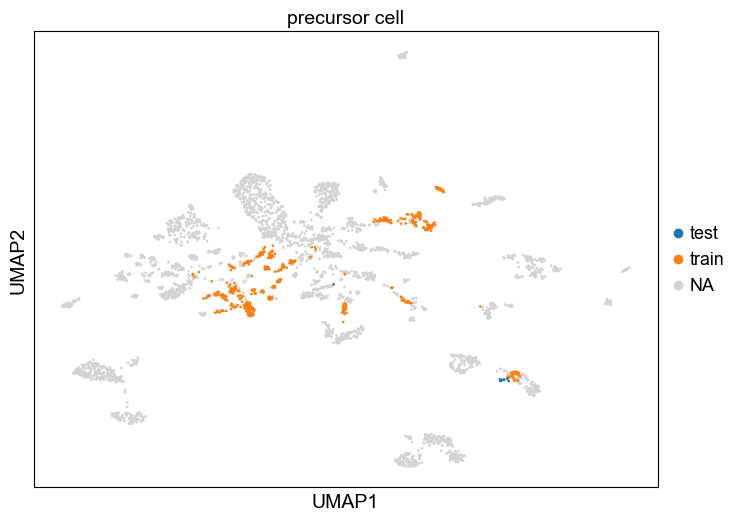

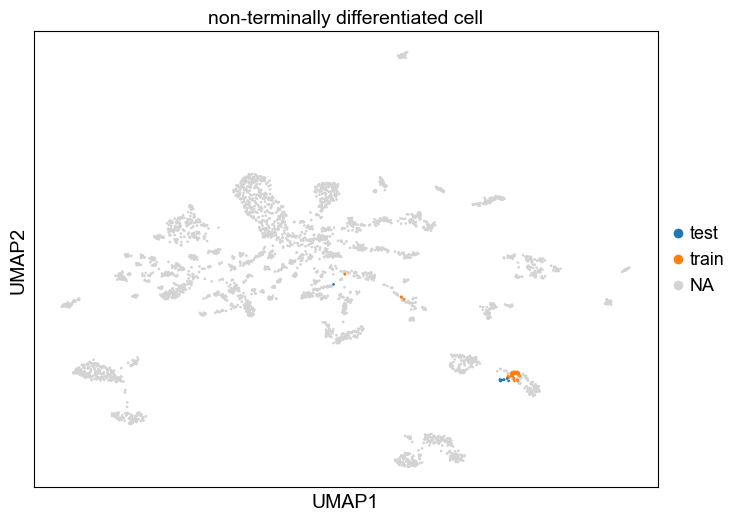

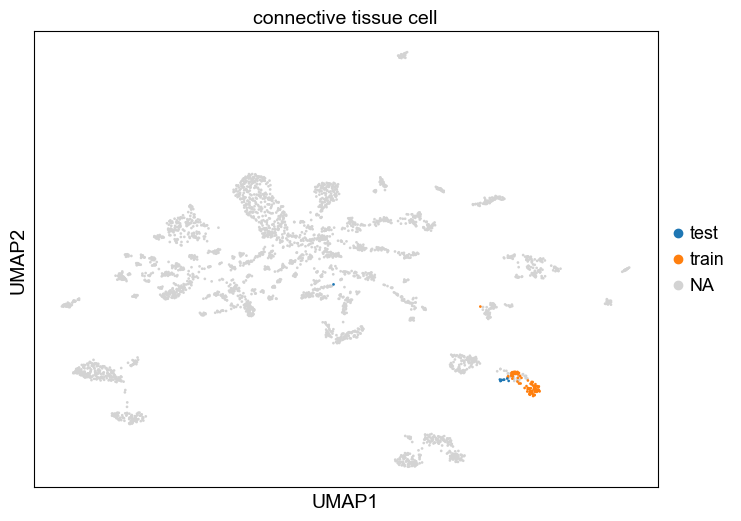

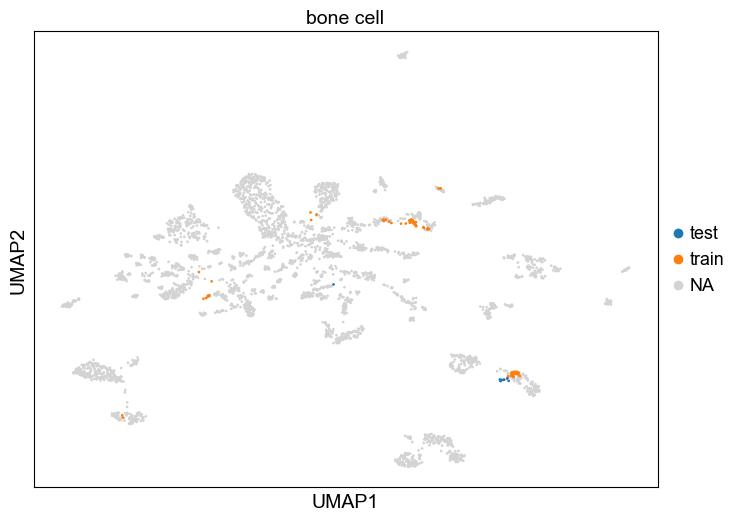

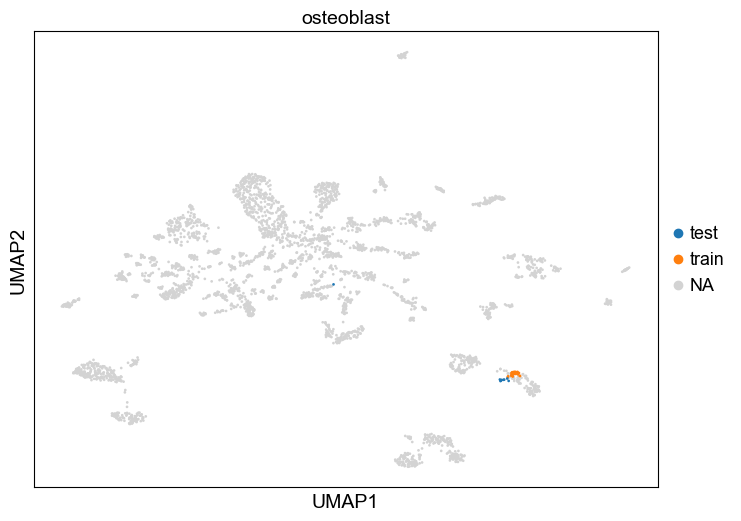

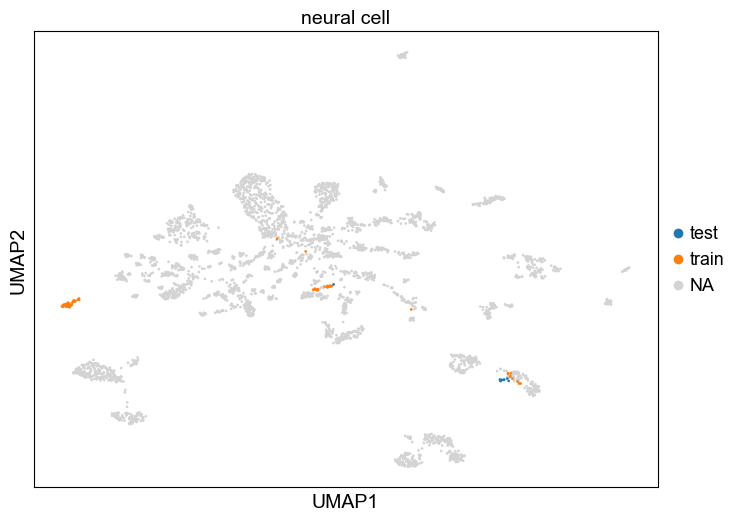

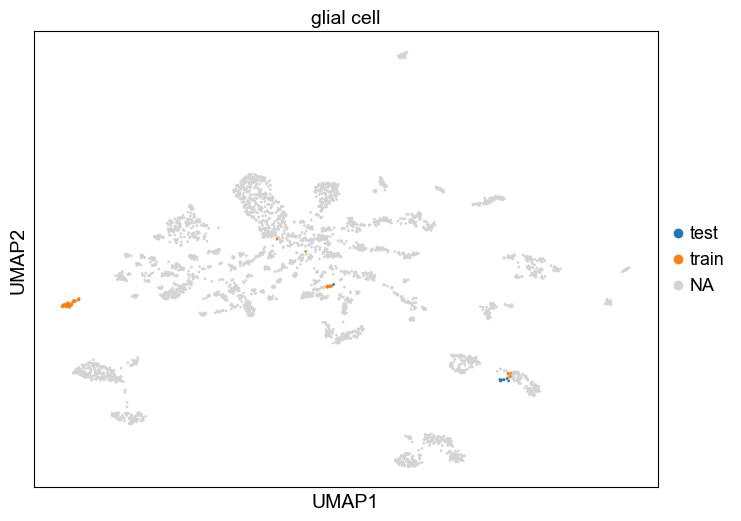

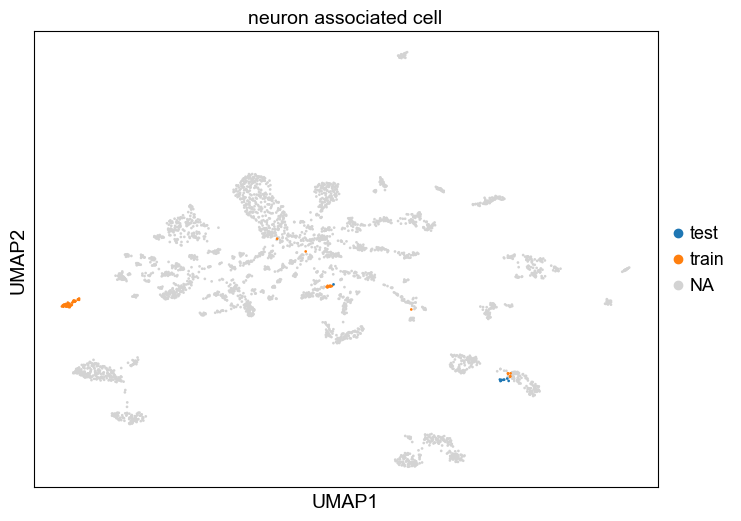

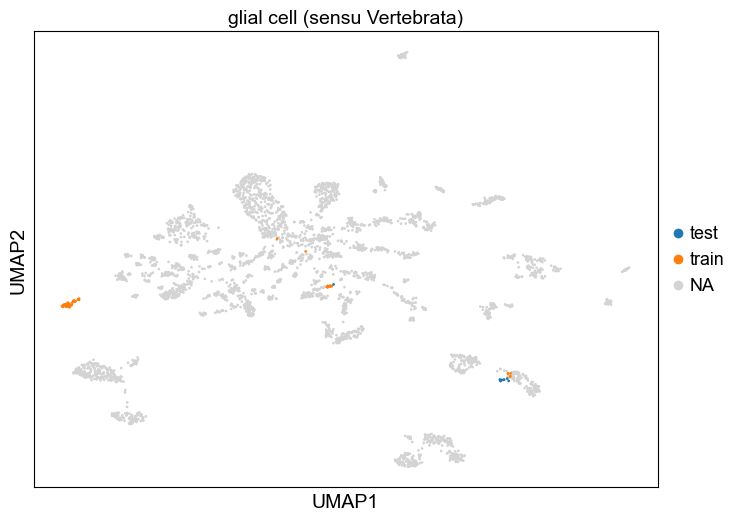

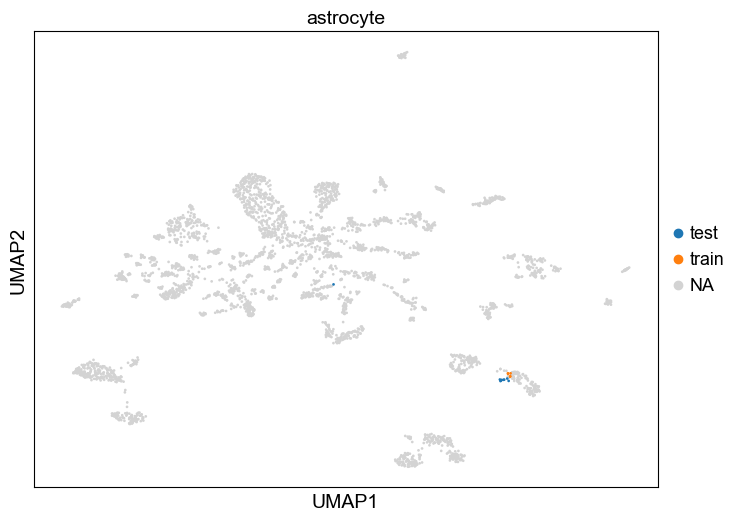

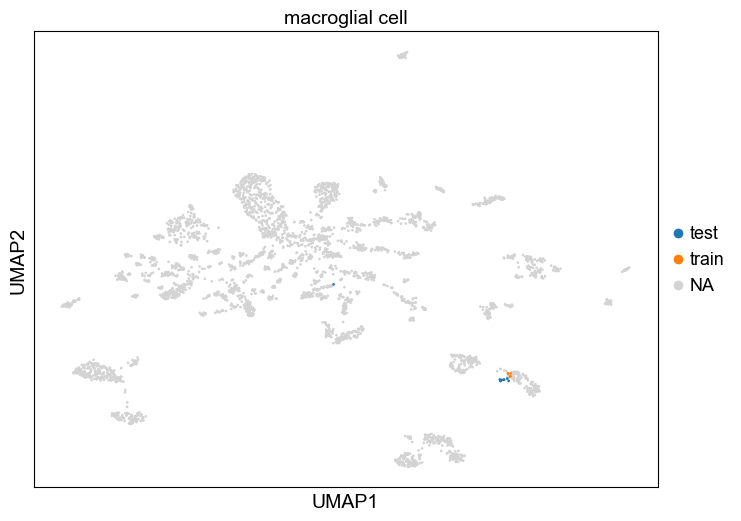

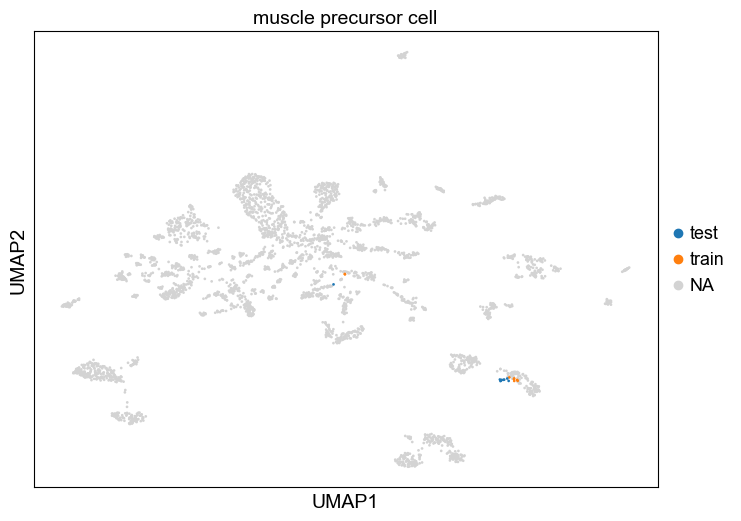

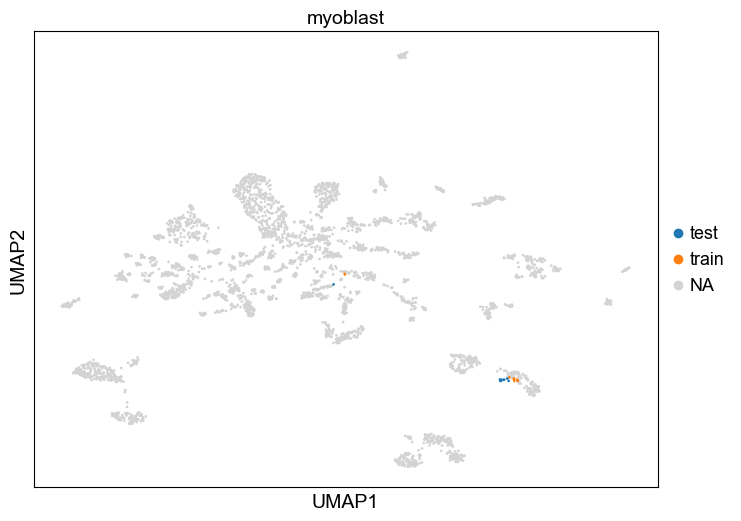

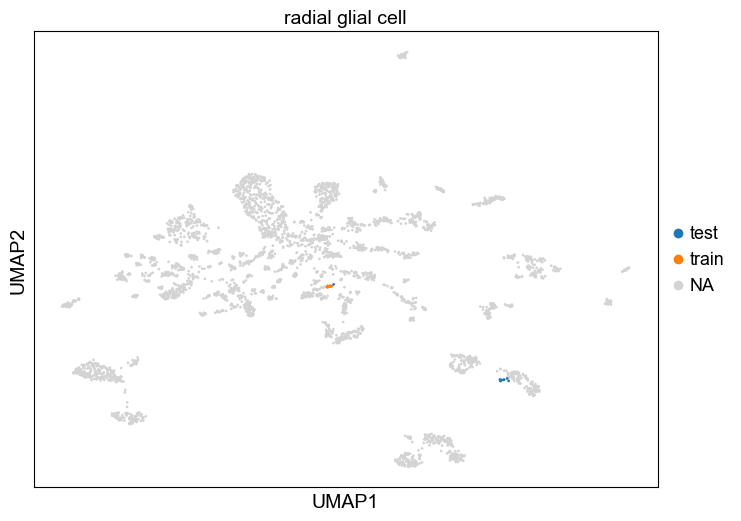

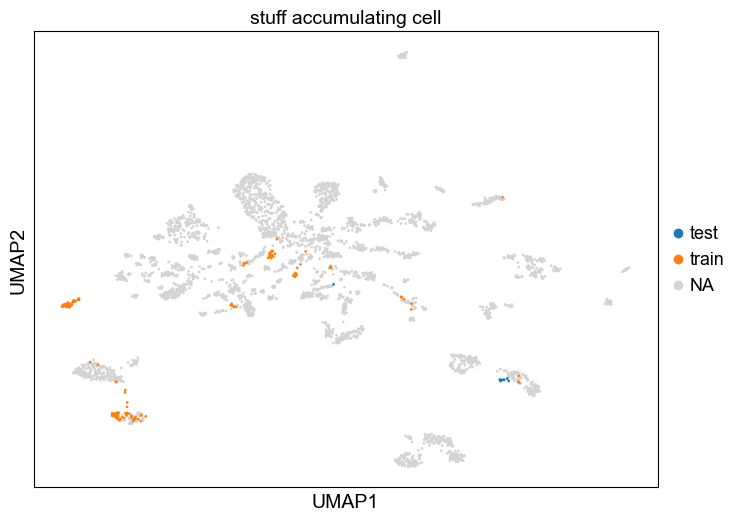

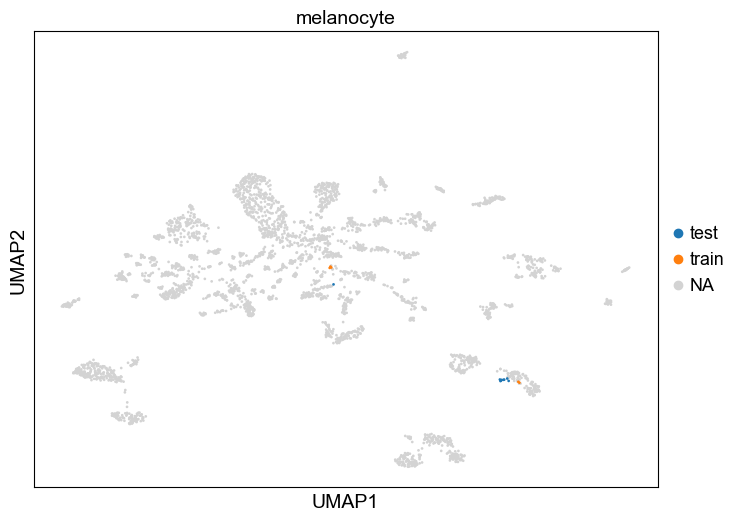

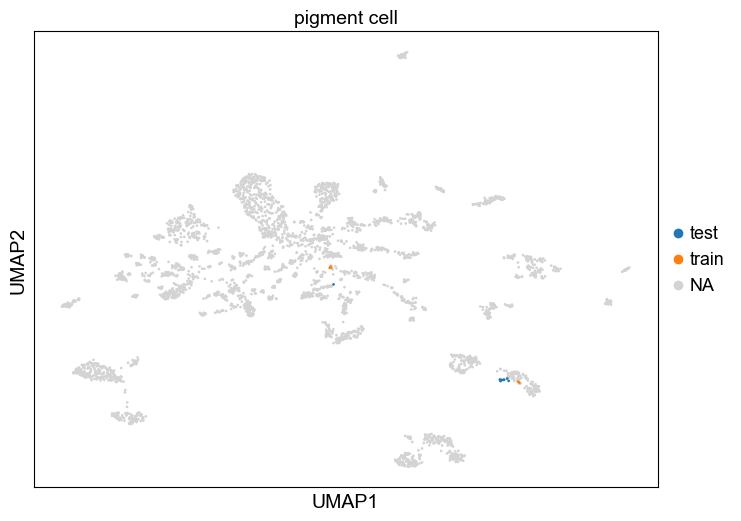

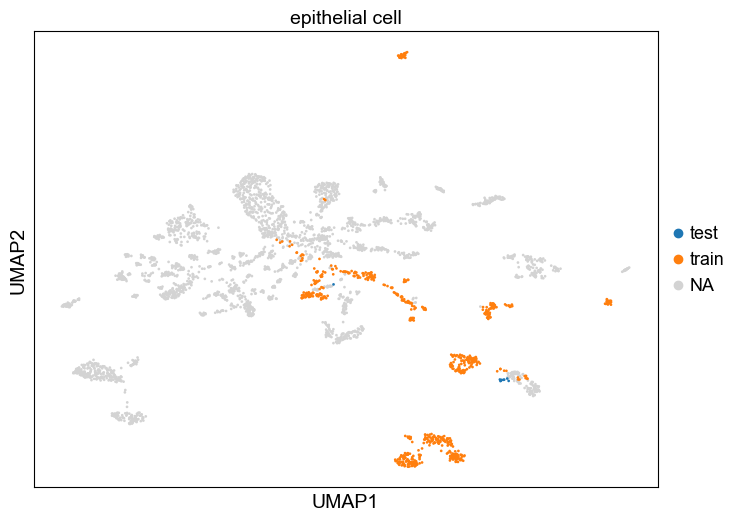

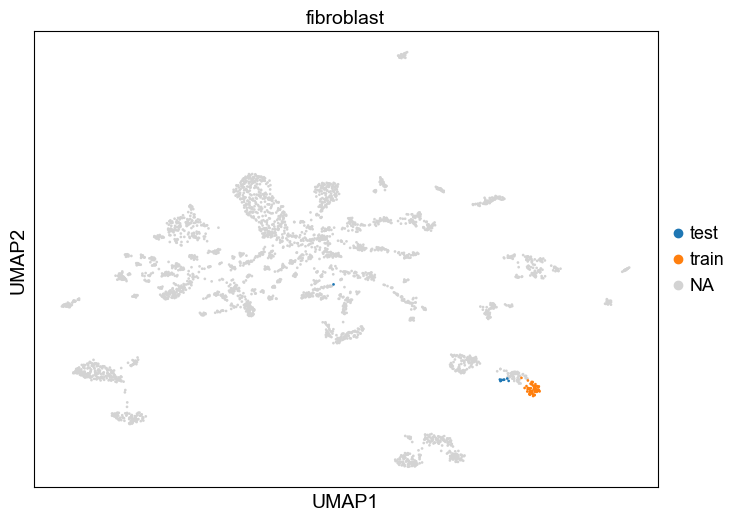

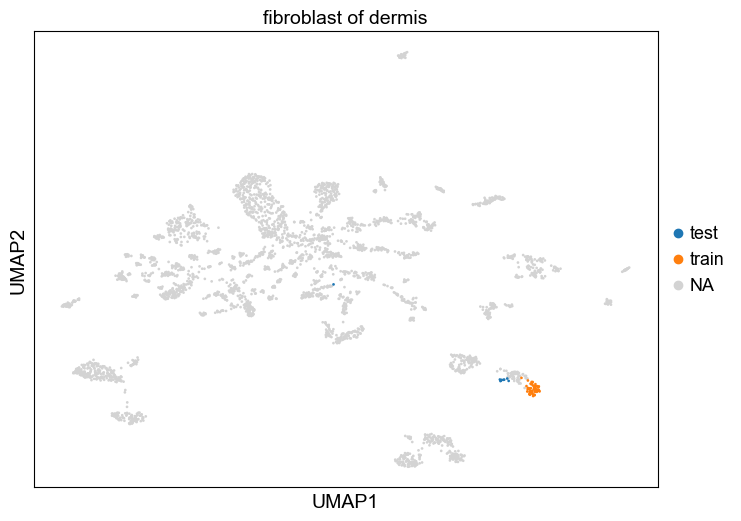

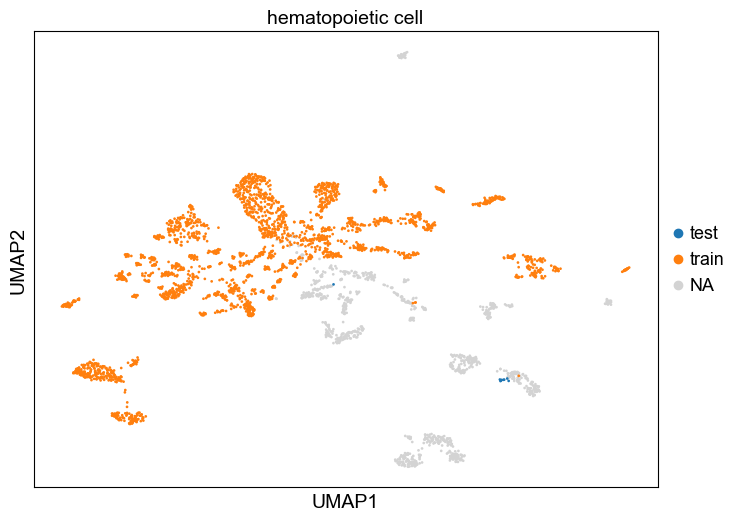

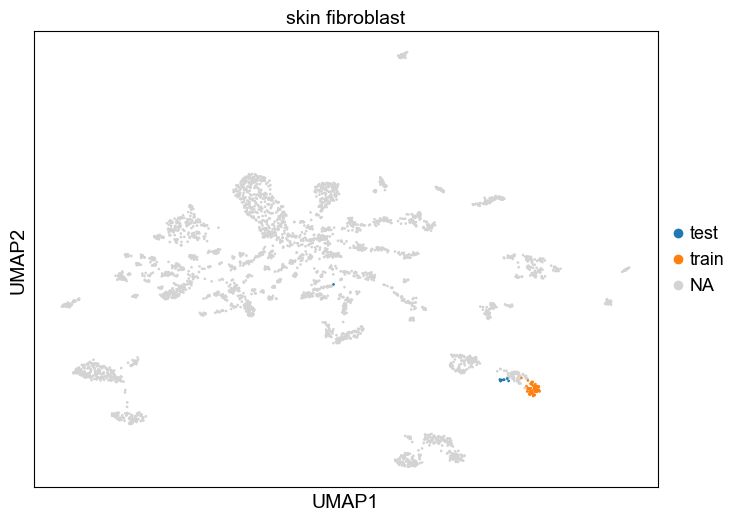

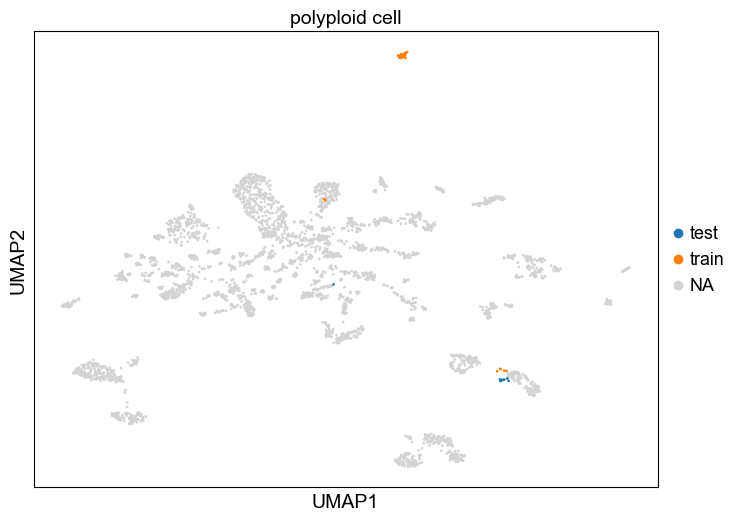

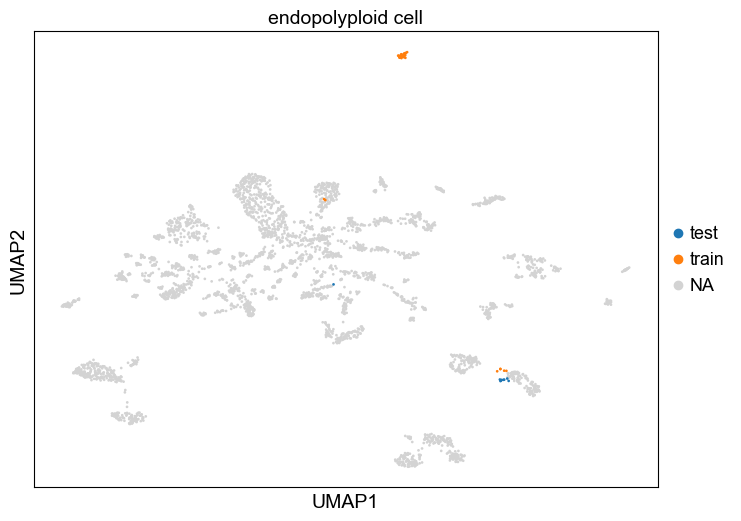

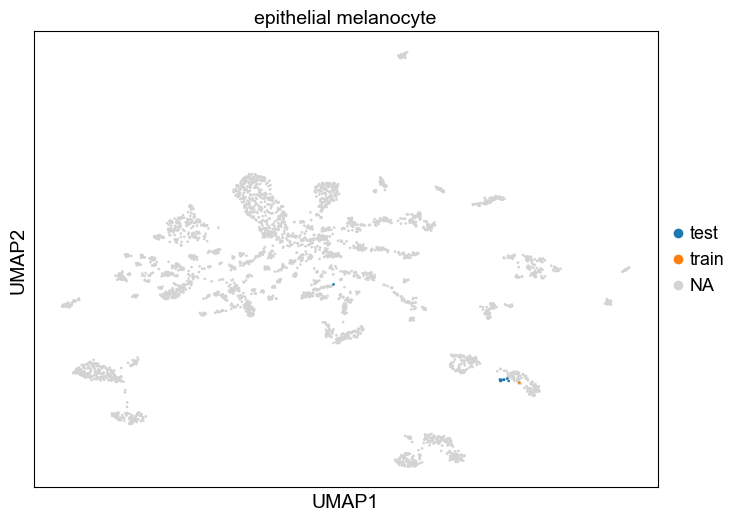

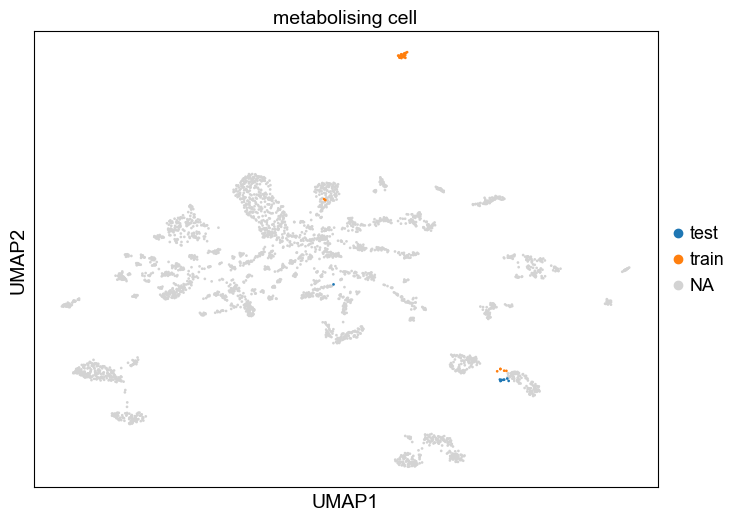

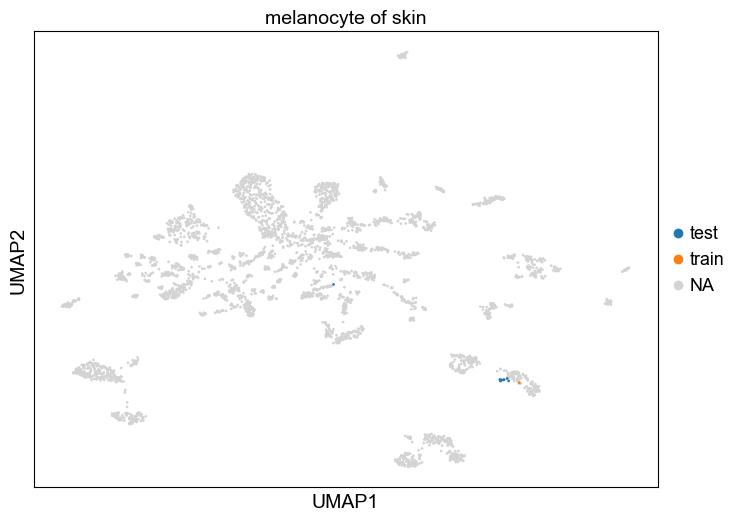

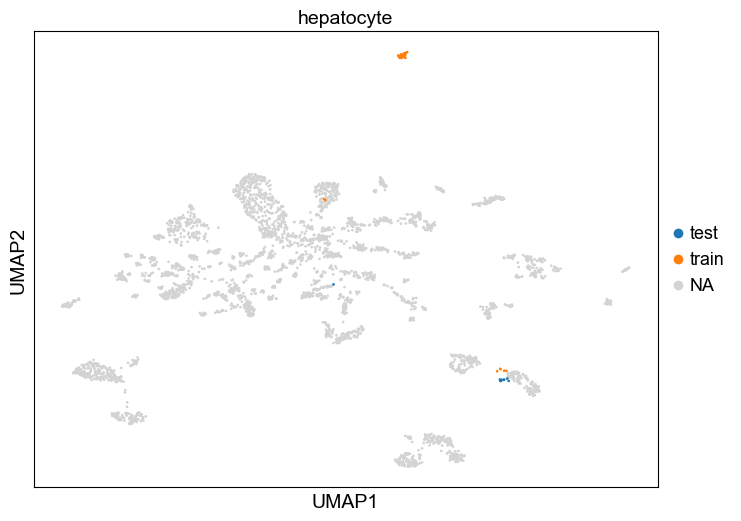

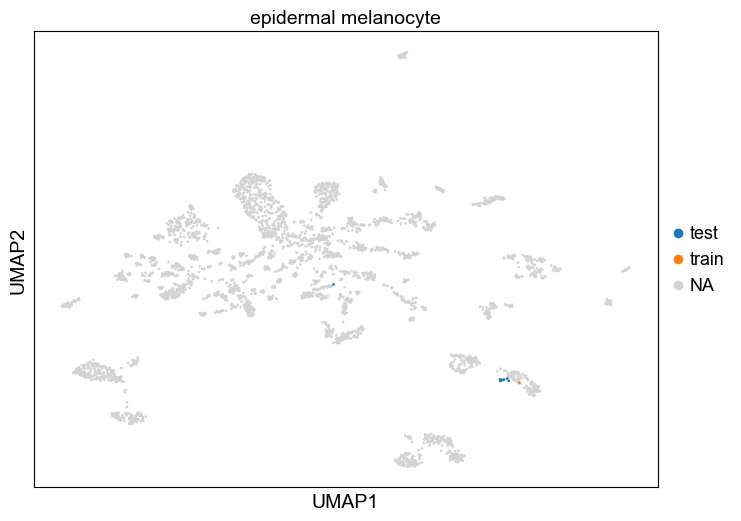

In [192]:
sc.set_figure_params(dpi=100)
plt.rcParams['figure.figsize'] = (8, 6)

for ctype in interesting_types.index:
    sc.pl.umap(ad, color=ctype, size=15, groups=['test', 'train'])